# Análisis del rendimiento de un jugador

En este cuaderno se aplicarán técnicas de aprendizaje automático para extraer información acerca de diversos factores relacionados con el rendimiento de un futbolista en el campo.

Para la realización de este experimento se parte del código desarrollado por el grupo Friends of Football, disponible en el repositorio https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython

In [1]:
# Librerías necesarias
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
np.seterr(divide='ignore', invalid='ignore') # Para que obvie las divisiones entre 0
import json
from FCPython import createPitch
import pandas as pd
import math
from matplotlib.transforms import Affine2D
## Regresión
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
## Clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# Tamaño del terreno de juego
pitchLengthX=120
pitchWidthY=80
goalLocationX = pitchLengthX
goalLocationY = pitchWidthY/2
# Colores para representaciones
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(0,12)]

## Evaluación de la calidad de un jugador para generar ocasiones

El fútbol es un deporte que se resumen en goles: aquel que consiga marcar más se hará con la victoria. Sin embargo, para ser un hecho tan importante es muy poco común durante los partidos y existe cierto componente aleatorio en la consecución de los mismos.

Por ello este fenómeno no puede ser usado para definir cómo ha jugado un equipo o un jugador en concreto ya que existen muchos factores influyentes. Existe una forma de medir cuantitativamente la calidad con la que un equipo o jugador ha desarrollado el partido: los goles esperados o **xG**. Esta se encarga de medir la probabilidad de que una jugada sea gol respecto a una serie de parámetros por lo que a mayor valor, mejor habrán sido las ocasiones generadas y, por tanto, mejor habrá jugado.

Esta predicción está basada en un modelo de regresión logística con una serie de atributos que varían en función de quién haya desarrollado dicho modelo y los datos disponibles. En este experimento se va a crear un modelo de goles esperados a través de los datos sobre eventos contenidos en el repositorio gratuito de StatsBomb.

### Primera aproximación

En primer lugar, se va a construir un modelo sencillo que presenta dos atributos: la posición y el ángulo a la portería. Para ello es necesaria una función que genere el dataset con los datos de entrenamiento para dicho modelo. Esta matriz tendrá un evento de disparo por fila y como columnas la posición (una clumna para la coordenada x y otra para la y), el ángulo respecto a la portería y si terminó en gol o no. Los datos de partida provienen de los eventos de los partidos ligueros jugados por el Arsenal en la temporada 2003/2004 y de las finales de la Champions League jugadas entre la 2003/2004 y la 2017/2018.

Hay que definir un par de funciones: una para obtener los datos necesarios para el entrenamiento a partir de los eventos de un partido determinado y otro para listar los partidos que se quieren utilizar en el entrenamiento. Se almacenará el nombre del jugador y el equipo al que pertenece para futuras aplicaciones.

In [2]:
# Datos de un partido
def get_train_data(match_id):
    file_name = 'open-data/data/events/'+str(match_id)+'.json'
    with open(file_name,encoding='UTF-8') as data_file:
        data = json.load(data_file,encoding='UTF-8')
    # Escoger los eventos de tiro provenientes, por el momento, de jugadas
    train = pd.json_normalize(data, sep='_')
    shots = train[(train['type_name'] == 'Shot')&(train['shot_type_name'] == 'Open Play')]
    # Obtener el dataframe final
    shots_model = pd.DataFrame(columns=['Goal','Team','Player','X','Y','Angle','Distance'])
    for i,shot in shots.iterrows():
        shots_model.at[i,'Team'] = shot['team_name']
        shots_model.at[i,'Player'] = shot['player_name']
        shots_model.at[i,'X'] = shot['location'][0]
        shots_model.at[i,'Y'] = pitchWidthY - shot['location'][1]
        # Es necesario calcular la distancia en metros (está en yardas) para obtener el ángulo en radianes.
        # Una yarda son 0.9144 metros
        # El centro de la portería está en (120,40), se calcula tomando como (0,0) el centro de la portería
        x = (goalLocationX - shots_model.at[i,'X'])/1.094
        y = abs(shots_model.at[i,'Y'] - goalLocationY)/1.094
        distance = np.sqrt(x**2 + y**2)
        shots_model.at[i,'Distance'] = distance*1.094 # Pasamos a yardas
        # La portería mide 7.32 metros (aproximadamente son 8 yardas)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a < 0:
            a = np.pi+a
        shots_model.at[i,'Angle'] = a
        #Es gol o no
        shots_model.at[i,'Goal'] = 0
        if shot['shot_outcome_name'] == 'Goal':
            shots_model.at[i,'Goal'] = 1
    return shots_model

def get_match_ids():
    match_ids = []
    file_name = 'open-data/data/competitions.json'
    with open(file_name,encoding='UTF-8') as data_file:
        data = json.load(data_file,encoding='UTF-8')
    df = pd.json_normalize(data, sep = '_')
    res = df[(df['competition_name'] == 'Champions League') | (df['competition_name'] == 'Premier League')].copy()
    for i, r in res.iterrows():
        with open('open-data/data/matches/'+ str(r['competition_id']) +'/'+ str(r['season_id']) +'.json', encoding='utf-8') as data_file:
                data = json.load(data_file)
        for match in data:
            match_ids.append(match['match_id'])
    return match_ids

Conseguir todos los datos iniciales es un proceso lento por lo que es recomendable guardarlos en un archivo en memoria, que en este caso será de tipo csv. De esta manera se podrán reutilizar todas las veces que se vuelva a inicar el kernel usando las siguientes funciones de lectura y escritura.

In [3]:
def write_dataset(dataframe,file_name = 'xg_train_data'):
    dataframe.to_csv('data/' + file_name + '.csv', index = False)
    print('Dataset almacenado, contiene ' + str(dataframe.shape[0]) + ' filas.')

def read_dataset(file_name = 'data/xg_train_data.csv'):
    df = pd.read_csv(file_name, header = 0)
    print('Dataset leído, contiene ' + str(df.shape[0]) + ' filas.')
    return df

Lo siguiente será utilizar las funciones para obtener los partidos, generar el listado e incluir cada disparo (con los atributos necesarios) en un dataset de entrenamiento, el cual se almacenará en memoria.

**La siguiente celda puede modificar todas las interpretaciones realizadas en el resto del experimento. Por lo tanto, si se quiere mantener la consistencia se debe ejecutar la celda posterior, diseñada para recuperar los datos de un archivo con los datos correctos.**

In [70]:
# Partidos
match_ids = get_match_ids()
shots_model_train = pd.DataFrame(columns=['Goal','Team','Player','X','Y','Angle','Distance'])
# Obtención de los disparos por partido
for m in match_ids:
    match_shots = get_train_data(m)
    shots_model_train = shots_model_train.append(match_shots, ignore_index=True)
# Se almacena el dataset en memoria
write_dataset(shots_model_train)

Dataset almacenado, contiene 1112 filas.


In [4]:
initial_data = read_dataset()

Dataset leído, contiene 1112 filas.


Es importante visualizar lo que se está construyendo, por lo que se van a representar algunos histogramas en dos dimensiones que muestren los tiros que se realizan por cada zona del campo y los tiros que acaban en gol por cada zona.

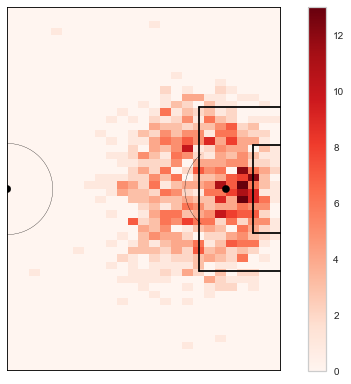

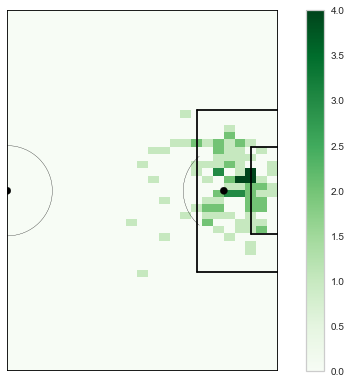

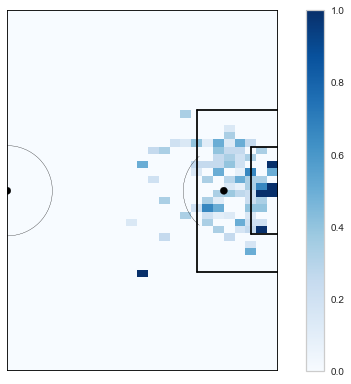

In [5]:
H_Shot = np.histogram2d(initial_data['X'], initial_data['Y'], bins=50, range=[[0, 120],[0, 80]])
goals_only = initial_data[initial_data['Goal']==1]
H_Goal = np.histogram2d(goals_only['X'], goals_only['Y'], bins=50, range=[[0, 120],[0, 80]])

# Representación de los disparos por zonas del terreno de juego
H1 = H_Shot[0].T
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
pos = ax.imshow(H1, extent=[0,120,80,0], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
plt.xlim((60,120))
plt.ylim((0,80))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('visual/num_shots.png')

# Representación de los goles por zonas del terreno de juego
H2 = H_Goal[0].T
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
pos = ax.imshow(H2, extent=[0,120,80,0], aspect='auto',cmap=plt.cm.Greens)
fig.colorbar(pos, ax=ax)
plt.xlim((60,120))
plt.ylim((0,80))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('visual/num_goals.png')

# Representación de la probabilidad de marcar
H3 = H2/H1
H3_ = np.nan_to_num(H3)
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
pos = ax.imshow(H3_, extent=[0,120,80,0], aspect='auto',cmap=plt.cm.Blues)
fig.colorbar(pos, ax=ax)
plt.xlim((60,120))
plt.ylim((0,80))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('visual/goal_probability.png')

Este sistema de predicción de goles no es muy acertado, pero si se puede considerar como una primera aproximación al xG. Es posible observar como los disparos más cercanos a la portería presentan una mayor probabilidad de acabar en la red. Sin embargo, existen zonas con una gran probabilidad que, gracias a la experiencia, se sabe que no son tan fiables. Esto se da porque son pocos los disparos realizados desde lugares lejanos en este dataset con la casualidad de que se han marcado la mayoría de ellos.

Otra causa para desechar este modelo es que el gol es un concepto muy aleatorio y está sujeto a una gran cantidad de factores, no solo a la posición en el campo. Se puede tener en cuenta la distancia a la portería, el ángulo de visión de esta, con qué parte del cuerpo se remate, la cantidad de defensas posicionados delante, etc. Por eso surge el xG: como no es posible predecir cuando será gol, se trata de evaluar la probabilidad de acercarse a él, es decir, cuán bueno es un lanzamiento.

### Construcción de un modelo simple

Se pretende obtener un modelo para evaluar los goles según la métrica xG. Para ello, se diseñará y entrenará un sistema basado en el algoritmo de aprendizaje supervisado de regresión logística con una serie de parámetros presentes en la base de datos gratuita de StatsBomb. Al principio del cuaderno ya se preparó una matriz con las columnas de distancia a la portería y el ángulo de visión de esta puesto que serán las primeras variables que alimenten el modelo. Se debe hacer un estudio de ellas para comprobar si tienen algún tipo de relación con el gol.

Comenzando con la distancia a la portería, se representará la probabilidad de que un disparo acabe en gol en función de esta. Para ello es recomendable apoyarse en la librería numpy y sus histogramas. De igual forma se hace con el ángulo de visión de la portería.

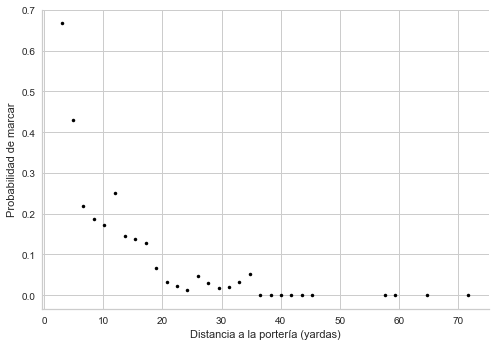

In [6]:
# Distancia
num_shots_dist = np.histogram(initial_data['Distance'],bins=40,range=[initial_data['Distance'].min(), initial_data['Distance'].max()])
num_goals_dist = np.histogram(goals_only['Distance'],bins=40,range=[initial_data['Distance'].min(), initial_data['Distance'].max()])
prob_dist = num_goals_dist[0]/num_shots_dist[0]
# La función np.histogram devuelve el valor en cada casilla junto a los límites de las casillas (array con longitud [n,n+1])
# Por ello se busca obtener el punto medio de cada una
distance = num_shots_dist[1]
middistance = (distance[:-1] + distance[1:])/2
# Representación
fig,ax = plt.subplots(num=1)
ax.plot(middistance, prob_dist, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probabilidad de marcar')
ax.set_xlabel('Distancia a la portería (yardas)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#fig.savefig('visual/prob_dist.png')

Los resultados son claramente aproximables a partir de una línea curva, tal y como se puede ver en el siguiente gráfico.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                 1112
Model:                            GLM   Df Residuals:                     1110
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -317.48
Date:                Tue, 31 Aug 2021   Deviance:                       634.97
Time:                        19:55:06   Pearson chi2:                 1.16e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0027      0.236     -0.012      0.9

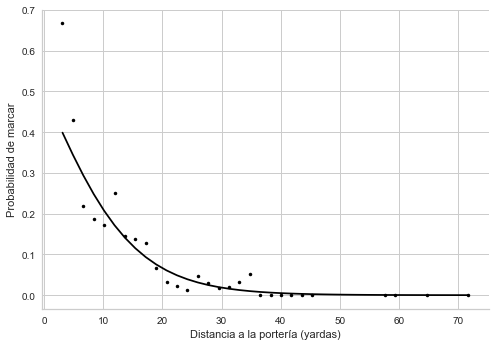

In [7]:
dist_model = smf.glm(formula="Goal ~ Distance" , data=initial_data, family=sm.families.Binomial()).fit()
print(dist_model.summary())        
coef = dist_model.params
xGprob = 1/(1+np.exp(coef[0]-coef[1]*middistance)) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_dist, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probabilidad de marcar')
ax.set_xlabel("Distancia a la portería (yardas)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()
#fig.savefig('visual/prob_dist_fun.png')

El resumen indica que el valor de intercepción apenas afecta a la variable dependiente (un 99% de probabilidades de no hacerlo). Por lo tanto, no es necesaria en el modelo y se elimina.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                 1112
Model:                            GLM   Df Residuals:                     1111
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -317.48
Date:                Tue, 31 Aug 2021   Deviance:                       634.97
Time:                        19:55:09   Pearson chi2:                 1.16e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Distance      -0.1326      0.007    -19.252      0.0

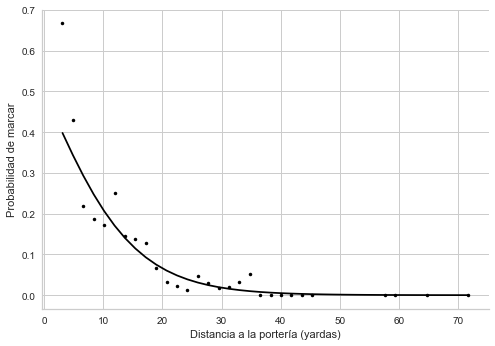

In [8]:
dist_model = smf.glm(formula="Goal ~ Distance -1" , data=initial_data, family=sm.families.Binomial()).fit()
print(dist_model.summary())        
coef = dist_model.params
xGprob = 1/(1+np.exp(-coef[0]*middistance)) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_dist, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probabilidad de marcar')
ax.set_xlabel("Distancia a la portería (yardas)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

A pesar de que la predicción con este línea de acopla muy bien a los datos iniciales, se trata de un polinomio y, por tanto, su valor aumenta hasta el infinito conforme se disminuye la distancia. Por ello se debe recurrir a un modelo de regresión logística, el cual otorgará una predicción entre 0 y 1 (como debería ser ya que se habla de probabilidad).

Optimization terminated successfully.
         Current function value: 0.285507
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   Goal   No. Observations:                 1112
Model:                          Logit   Df Residuals:                     1110
Method:                           MLE   Df Model:                            1
Date:                Tue, 31 Aug 2021   Pseudo R-squ.:                  0.1312
Time:                        19:55:12   Log-Likelihood:                -317.48
converged:                       True   LL-Null:                       -365.43
Covariance Type:            nonrobust   LLR p-value:                 1.212e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0027      0.236     -0.012      0.991      -0.464       0.459
Distance      -0.1324      0.

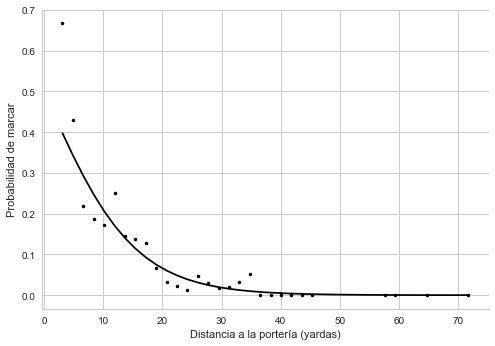

In [9]:
log_dist_model = smf.logit(formula="Goal ~ Distance" , data=initial_data).fit()
print(log_dist_model.summary())        
coef = log_dist_model.params
xGprob = 1/(1+np.exp(-coef[0] - coef[1]*middistance)) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_dist, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probabilidad de marcar')
ax.set_xlabel("Distancia a la portería (yardas)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

Esta claro que cuanto mayor sea la distancia entre el jugador dispuesto a lanzar y la portería, menor es la probabilidad de que la acción acabe en gol.

Con el atributo de ángulos ocurre algo parecido a lo comentado anteriormente: también puede aproximarse a una curva. Aunque se debe mencionar que debido a la poca cantidad de goles con gran ángulo pueda ser un ejemplo complicado.

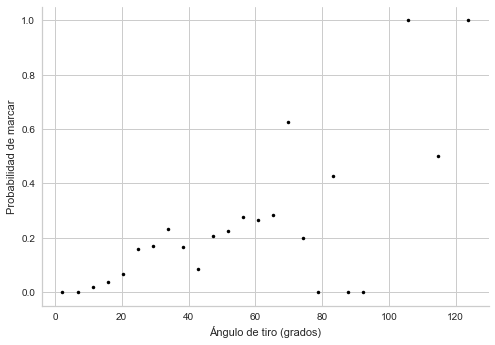

In [10]:
# Ángulo
# Se pasarán los radianes a grados para facilitar la compresión
degree_angle = initial_data['Angle']*180/np.pi
angle_data = initial_data.assign(AngleDegree=degree_angle)
num_shots_angle = np.histogram(angle_data['AngleDegree'],bins=40,range=[0,180])
angle_goals_only = angle_data[angle_data['Goal']==1]
num_goals_angle = np.histogram(angle_goals_only['AngleDegree'],bins=40,range=[0,180])
prob_angle = num_goals_angle[0]/num_shots_angle[0]
# La función np.histogram devuelve el valor en cada casilla junto a los límites de las casillas (array con longitud [n,n+1])
# Por ello se busca obtener el punto medio de cada una
angle = num_shots_angle[1]
midangle = (angle[:-1] + angle[1:])/2
# Representación
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_angle, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probabilidad de marcar')
ax.set_xlabel("Ángulo de tiro (grados)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
#fig.savefig('visual/prob_angle.png')

De igual forma que ocurría con el otro atributo, se busca una probabilidad y es por eso por lo que se vuelve a usar regresión logística.

Optimization terminated successfully.
         Current function value: 0.295146
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   Goal   No. Observations:                 1112
Model:                          Logit   Df Residuals:                     1110
Method:                           MLE   Df Model:                            1
Date:                Tue, 31 Aug 2021   Pseudo R-squ.:                  0.1019
Time:                        19:55:18   Log-Likelihood:                -328.20
converged:                       True   LL-Null:                       -365.43
Covariance Type:            nonrobust   LLR p-value:                 6.193e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.4615      0.200    -17.288      0.000      -3.854      -3.069
AngleDegree     0.0437    

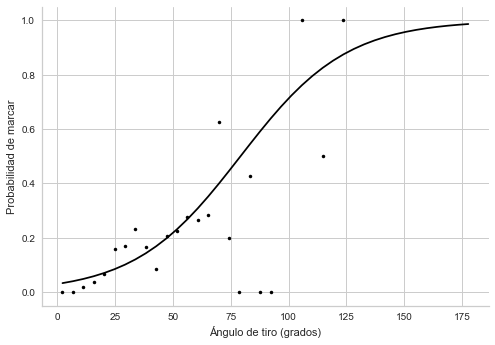

In [11]:
angle_model = smf.logit(formula="Goal ~ AngleDegree" , data=angle_data).fit()
print(angle_model.summary())        
coef = angle_model.params
xGprob_angle = 1/(1+np.exp(-coef[0] - coef[1]*midangle)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_angle, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probabilidad de marcar')
ax.set_xlabel("Ángulo de tiro (grados)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(midangle, xGprob_angle, linestyle='solid', color='black')
plt.show()
#fig.savefig('visual/prob_angle_fun.png')

El modelo tiene sentido: un mayor ángulo de tiro supondrá una mayor probabilidad de que un disparo acabe en gol (no es lo mismo disparar desde el córner que desde la línea de gol, con total probabilidad de marcar).

Vista la influencia de ambos atributos en un gol, ¿por qué no construir un modelo con ambos? De esta forma se tendrían en cuenta dos parámetros que en la vida real no surgen separados y, por tanto, daría una predicción más realista de lo que es la probabilidad de que un lanzamiento acabe en la red rival.

In [12]:
complete_model = smf.logit(formula="Goal ~ Distance + Angle" , data=initial_data).fit()        
coef = complete_model.params
# Función para calcular el xG
def get_xG(row):
    bsum = -coef[0] - coef[1]*row['Distance'] - coef[2]*row['Angle']
    xG = 1/(1+np.exp(bsum)) 
    return xG

Optimization terminated successfully.
         Current function value: 0.284937
         Iterations 8


Con el modelo creado, es momento de mostrar la probabilidad de goles en el terreno de juego para poder evaluar el buen hacer de esta métrica desarrollada.

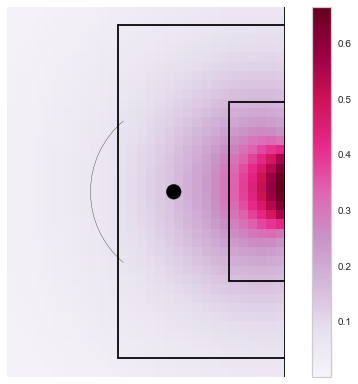

In [13]:
# Mapa de valores xG por cada zona del campo
pgoal_2d=np.zeros((120,80))
for x in range(120):
    for y in range(80):
        sh=dict()
        x_ = (goalLocationX - x)/1.094
        y_ = abs(y - goalLocationY)/1.094
        distance = np.sqrt(x_**2 + y_**2)
        a = np.arctan(7.32 *x_ /(x_**2 + y_**2 - (7.32/2)**2))
        if a < 0:
            a = np.pi+a
        sh['Angle'] = a
        sh['Distance'] = distance*1.094 # Pasamos a yardas
        pgoal_2d[x,y] =  get_xG(sh)
        
# Representación
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
pos = ax.imshow(pgoal_2d.T, extent=[0,120,80,0], aspect='auto',cmap=plt.cm.PuRd)
fig.colorbar(pos, ax=ax)
plt.xlim((90,120))
plt.ylim((20,60))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('visual/xg_angle-distance.png')

Los resultados son concluyentes según lo que se ha ido observando durante las partes del experimento.

### Mejoras

Aunque el sistema obtenido responda con una salida aceptable es importante recordar que los factores escogidos no son los únicos que influyen en la probabilidad de que un disparo finalice dentro de la portería. Por ello, en este epígrafe se va a tratar de mejorar el rendimiento de este para que se acerque aún más a la realidad. Se van a estudiar distintos atributos que están presentes en la base de datos de StatsBomb y, si son adecuados, se añadirán al modelo ya creado.

En el dataset de la empresa podemos ver propiedades del tiro que pueden ser de utilidad, por ejemplo: si el disparo proviene de un duelo aéreo, si se lanzó al primer toque o de si la portería está vacía cuando se dispara. Vamos a estudiar la influencia de esos factores en el gol.

In [14]:
# Función para obtener los datos de un partido con los nuevos factores
def get_train_data_improvements(match_id):
    file_name = 'open-data/data/events/'+str(match_id)+'.json'
    with open(file_name,encoding='UTF-8') as data_file:
        data = json.load(data_file,encoding='UTF-8')
    # Escoger los eventos de tiro provenientes de jugadas
    train = pd.json_normalize(data, sep='_')
    shots = train[(train['type_name'] == 'Shot')&(train['shot_type_name'] == 'Open Play')]
    # Obtener el dataframe final
    shots_model = pd.DataFrame(columns=['Goal','Team','Player','X','Y','Angle','Distance','F_Touch','Aerial','Open'])
    for i,shot in shots.iterrows():
        shots_model.at[i,'Team'] = shot['team_name']
        shots_model.at[i,'Player'] = shot['player_name']
        shots_model.at[i,'X'] = shot['location'][0]
        shots_model.at[i,'Y'] = pitchWidthY - shot['location'][1]
        # Es necesario calcular la distancia en metros (está en yardas) para obtener el ángulo en radianes.
        # Una yarda son 0.9144 metros
        # El centro de la portería está en (120,40), se calcula tomando como (0,0) el centro de la portería
        x = (goalLocationX - shots_model.at[i,'X'])/1.094
        y = abs(shots_model.at[i,'Y'] - goalLocationY)/1.094
        distance = np.sqrt(x**2 + y**2)
        shots_model.at[i,'Distance'] = distance*1.094 # Pasamos a yardas
        # La portería mide 7.32 metros (aproximadamente son 8 yardas)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a < 0:
            a = np.pi+a
        shots_model.at[i,'Angle'] = a
        # Es al primer toque
        shots_model.at[i,'F_Touch'] = 0
        if 'shot_first_time' in shot and shot['shot_first_time'] == True:
            shots_model.at[i,'F_Touch'] = 1
        # Es duelo aéreo
        shots_model.at[i,'Aerial'] = 0
        if 'shot_aerial_won' in shot and shot['shot_aerial_won'] == True:
            shots_model.at[i,'Aerial'] = 1
        # Está la portería vacía
        shots_model.at[i,'Open'] = 0
        if 'shot_open_goal' in shot and shot['shot_open_goal'] == True:
            shots_model.at[i,'Open'] = 1
        # Es gol
        shots_model.at[i,'Goal'] = 0
        if shot['shot_outcome_name'] == 'Goal':
            shots_model.at[i,'Goal'] = 1
    return shots_model

Se genera el nuevo dataset y se escribe en un fichero para su posterior uso.

**La siguiente celda puede modificar todas las interpretaciones realizadas en el resto del experimento. Por lo tanto, si se quiere mantener la consistencia se debe ejecutar la celda posterior, diseñada para recuperar los datos de un archivo con los datos correctos.**

In [85]:
# Partidos
match_ids = get_match_ids()
shots_model_train_ = pd.DataFrame(columns=['Goal','Team','Player','X','Y','Angle','Distance','F_Touch','Aerial','Open'])
# Obtención de los disparos por partido
for m in match_ids:
    match_shots = get_train_data_improvements(m)
    shots_model_train_ = shots_model_train_.append(match_shots, ignore_index=True)
# Se almacena el dataset en memoria
write_dataset(shots_model_train_, file_name='xg_improvements_train_data')

Dataset almacenado, contiene 1112 filas.


In [15]:
# Lectura en nueva variable
new_initial_data = read_dataset('data/xg_improvements_train_data.csv')

Dataset leído, contiene 1112 filas.


Con los datos incluidos en el dataset de entrenamiento se procede a estudiar estos nuevos atributos.

En el dataset hay 78 disparos provenientes de un duelo aéreo, 361 con golpeo al primer toque y 12 a puerta vacía.


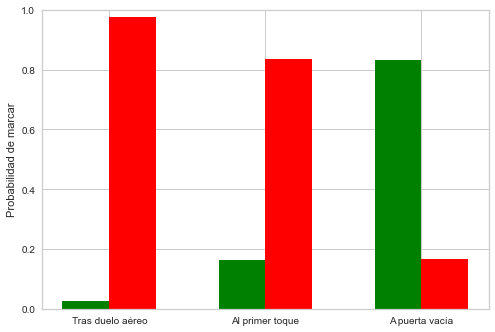

In [16]:
# Cálculo de los datos
num_aerial = new_initial_data[new_initial_data['Aerial'] == 1].shape[0]
num_aerial_goals = new_initial_data[(new_initial_data['Aerial'] == 1) & (new_initial_data['Goal'] == 1)].shape[0]
aerial_prob = num_aerial_goals/num_aerial 
num_first_touch = new_initial_data[new_initial_data['F_Touch'] == 1].shape[0]
num_first_touch_goals = new_initial_data[(new_initial_data['F_Touch'] == 1) & (new_initial_data['Goal'] == 1)].shape[0]
first_touch_prob = num_first_touch_goals/num_first_touch
num_open = new_initial_data[new_initial_data['Open'] == 1].shape[0]
num_open_goals = new_initial_data[(new_initial_data['Open'] == 1) & (new_initial_data['Goal'] == 1)].shape[0]
open_prob = num_open_goals/num_open
print('En el dataset hay ' + str(num_aerial) + ' disparos provenientes de un duelo aéreo, ' + str(num_first_touch)
      + ' con golpeo al primer toque y ' + str(num_open) + ' a puerta vacía.')

# Representación (obtenida a través del ejemplo https://people.duke.edu/~ccc14/pcfb/numpympl/MatplotlibBarPlots.html)
fig,ax=plt.subplots(num=1)
ind = np.arange(3)
width = 0.3
goal_pb = [aerial_prob,first_touch_prob,open_prob]
no_goal_pb = [1-aerial_prob,1-first_touch_prob,1-open_prob]

prob_bar = ax.bar(ind, goal_pb, width,color='green')
no_prob_bar = ax.bar(ind+width, no_goal_pb, width,color='red')

# ax.set_xlim(-width,len(ind))
ax.set_ylim(0,1)
ax.set_ylabel('Probabilidad de marcar')
marcas = ['Tras duelo aéreo','Al primer toque','A puerta vacía']
ax.set_xticks(ind+width/2)
nombres = ax.set_xticklabels(marcas)
plt.setp(nombres, fontsize=10)
# ax.legend( (prob_bar[0], no_prob_bar[0]),('Marcar', 'Fallar'))
plt.show()
#fig.savefig('visual/prob_new_facts.png')

Se ha representado en verde la probabilidad de anotar y, en rojo, la de que no acabe en gol. Según esta gráfica, las posibilidades de marcar si el disparo proviene de un duelo aéreo son muy pequeñas, igual que se se hace al primer toque. En cambio, si la portería está vacía las posibilidades se disparan. Se podría decir que todos estos factores tienen influencia sobre el resultado de un tiro, por lo que se pueden incluir en el modelo.

Aun así, en aquellos ámbitos sobre los que se tenga poco conocimiento no es recomendable usar resultados provenientes de tan pocos ejemplos como los 12 disparos a puerta vacía. Gracias a haber practicado fútbol y haber visto muchos partidos es común decir que esa probabilidad está en lo cierto a pesar de existir tan pocos ejemplos.

Con ello se comienza a entrenar el modelo de regresión logística.

In [17]:
# Como el número de variables ha aumentado, se va a utilizar otro tipo de funciones de la librería statsmodels
x_train = new_initial_data[['Angle','Distance','F_Touch','Aerial','Open']]
y_train = new_initial_data[['Goal']]
new_model = sm.Logit(y_train, x_train).fit()
print(new_model.summary())

Optimization terminated successfully.
         Current function value: 0.263081
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   Goal   No. Observations:                 1112
Model:                          Logit   Df Residuals:                     1107
Method:                           MLE   Df Model:                            4
Date:                Tue, 31 Aug 2021   Pseudo R-squ.:                  0.1994
Time:                        19:56:25   Log-Likelihood:                -292.55
converged:                       True   LL-Null:                       -365.43
Covariance Type:            nonrobust   LLR p-value:                 1.640e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Angle          0.1238      0.235      0.528      0.598      -0.336       0.583
Distance      -0.1436      0.

El modelo ha sido entrenado satisfactoriamente aunque la métrica seudo R al cuadrado, parecida a la R al cuadrado y que se encarga de medir la capacidad de un modelo para predecir futuros resultados, es cercana al 20 %; un valor muy pequeño. Esto quiere decir que el modelo no es recomendable para predecir si una jugada acabará en gol, pero este no era el fin del sistema ya que el gol es aleatorio. El objetivo era ser capaces de evaluar la calidad de un disparo.

### Pruebas

Para probar el modelo se usarán los datos de la liga española del dataset de StatsBomb. Se identificarán un subconjunto de jugadores para medir los disparos que salen de sus botas y se realizará una media de valoración por lanzamiento. Si el modelo actúa bien, aquellos jugadores con mayor capacidad goleadora deben tener los valores más altos.

Los partidos de la liga española son los del F.C. Barcelona por lo que la mayoría de disparos pertenecerán a ese club. Para no realizar pruebas con jugadores culés se escogerán futbolistas de otros equipos con cantidades altas de lanzamientos. Se procede a seleccionar los partidos a partir de los que se extraerán los datos de disparos y, posteriormente, se identificarán los sujetos de prueba.

In [18]:
# Partidos del Barça de tres temporadas
def match_ids_season(season):
    match_ids = []
    file_name = 'open-data/data/competitions.json'
    with open(file_name,encoding='UTF-8') as data_file:
        data = json.load(data_file,encoding='UTF-8')
    df = pd.json_normalize(data, sep = '_')
    res = df[(df['competition_name'] == 'La Liga')&(df['season_name'] == season)].copy()
    with open('open-data/data/matches/'+str(res['competition_id'].values[0])+'/'+str(res['season_id'].values[0])+'.json',
              encoding='utf-8') as data_file:
            data = json.load(data_file)
    for match in data:
        match_ids.append(match['match_id'])
    return match_ids

In [19]:
test_matches = []
for season in ['2017/2018','2018/2019','2019/2020']:
    match_ids = match_ids_season(season)
    test_matches = test_matches + match_ids
print('Se han almacenado ' + str(len(test_matches)) + ' partidos del F.C. Barcelona')

Se han almacenado 103 partidos del F.C. Barcelona


Se debe crear el dataset con los datos de prueba a partir de los partidos obtenidos y se escribe en un fichero para su posterior uso.

**La siguiente celda puede modificar todas las interpretaciones realizadas en el resto del experimento. Por lo tanto, si se quiere mantener la consistencia se debe ejecutar la celda posterior, diseñada para recuperar los datos de un archivo con los datos correctos.**

In [90]:
# Carga del dataset de prueba
# Partidos
match_ids = test_matches
shots_model_train_ = pd.DataFrame(columns=['Goal','Team','Player','X','Y','Angle','Distance','F_Touch','Aerial','Open'])
# Obtención de los disparos por partido
for m in match_ids:
    match_shots = get_train_data_improvements(m)
    shots_model_train_ = shots_model_train_.append(match_shots, ignore_index=True)
# Se almacena el dataset en memoria
write_dataset(shots_model_train_, file_name='xg_improvements_test_data')

Dataset almacenado, contiene 2386 filas.


In [20]:
test_data = read_dataset('data/xg_improvements_test_data.csv')

Dataset leído, contiene 2386 filas.


In [21]:
# Jugadores y el número de disparos
players = test_data.groupby('Player')['Player'].agg('count').to_frame(name='Count').sort_values(by='Count',ascending=False).reset_index()
print(players[0:5])
# Jugadores que no sean del F.C. Barcelona
no_barsa_players = test_data[test_data['Team'] != 'Barcelona']
no_barsa_players_ = no_barsa_players.groupby('Player')['Player'].agg('count').to_frame(name='Count').sort_values(by='Count',ascending=False).reset_index()
print(no_barsa_players_[0:5])
# Jugadores a estudiar
test_players = players['Player'][:5].tolist() + no_barsa_players_['Player'][:5].tolist()

                           Player  Count
0  Lionel Andrés Messi Cuccittini    384
1        Luis Alberto Suárez Díaz    265
2       Philippe Coutinho Correia     88
3                    Ivan Rakitić     81
4                 Ousmane Dembélé     53
                                Player  Count
0          Samuel Chimerenka Chukwueze     14
1                Willian José da Silva     14
2           Luis Fernando Muriel Fruto     13
3            Ángel Luis Rodríguez Díaz     11
4  Cristiano Ronaldo dos Santos Aveiro     10


Como era de esperar, existen muchas más instancias de disparos de jugadores del F.C. Barcelona que de otros equipos. Sin embargo, se va a calcular el xG medio por disparo para tener un conjunto de jugadores que no se limite exclusivamente a los del conjunto catalán.

In [22]:
# Cálculo del xG
def get_players_xG(players):
    res = pd.DataFrame(columns=['Player','Team','Shots','Mean xG'])
    for i,player in enumerate(players):
        player_shots = test_data[test_data['Player'] == player]
        xG_pred = new_model.predict(player_shots[['Angle','Distance','F_Touch','Aerial','Open']])
        res.loc[i] = [player, player_shots.iloc[0]['Team'], player_shots.shape[0], xG_pred.agg('mean')]
    return res

players_xg = get_players_xG(test_players).sort_values(by='Mean xG',ascending=False,ignore_index=True)
players_xg

,Player,Team,Shots,Mean xG
0,Luis Alberto Suárez Díaz,Barcelona,265,0.180346
1,Cristiano Ronaldo dos Santos Aveiro,Real Madrid,10,0.160181
2,Willian José da Silva,Real Sociedad,14,0.159812
3,Lionel Andrés Messi Cuccittini,Barcelona,384,0.120069
4,Ousmane Dembélé,Barcelona,53,0.116135
5,Ángel Luis Rodríguez Díaz,Getafe,11,0.109729
6,Samuel Chimerenka Chukwueze,Villarreal,14,0.092856
7,Philippe Coutinho Correia,Barcelona,88,0.087131
8,Luis Fernando Muriel Fruto,Sevilla,13,0.076154
9,Ivan Rakitić,Barcelona,81,0.070392


Los resultados son los esperados ya que mientras que jugadores que no son delanteros obtienen valores inferiores (Rakitic, Coutinho, etc.), los delanteros más goleadores del campeonato (Messi, Suárez y Cristiano Ronaldo) obtienen las puntuaciones más altas.

## Estudio de los tipos de pases de un jugador

Otra faceta muy importante del fútbol son los pases ya que, junto a las conducciones de balón, son los pilares de construcción de las jugadas. En este terreno, un jugador que con sus pases sea capaz de provocar oportunidades claras de gol es considerado como un gran pasador y tomará un rol importante en torno a la posición de centrocampista de un equipo. ¿Qué jugador sería más útil para nuestros delanteros? o ¿cómo podemos parar al gran pasador del equipo contrario?. Ambas son cuestiones que se realizan los entrenadores y con el sistema a desarrollar se pretende dar una solución a ellas, entre otras muchas.

Esta parte del experimento consiste en la aplicación de un algoritmo de clustering sobre los atributos de pases de un determinado jugador. Con ello se pretende descubrir qué patrones se ocultan en su estilo de juego para que se puedan maximizar algunos tipos de pases o neutralizarlos (si el jugador está en el equipo contrario). Los datos sobre los que se aplica esta estrategia corresponden a los eventos de los partidos de las temporadas ligueras del F.C. Barcelona presentes en la base de datos de StatsBomb.

### Tratamiento de los datos

El primer paso consiste en escoger los partidos a estudiar y separar los pases del resto de eventos. Como aproximación al resultado final se estudiará sobre un solo encuentro para ver el desempeño del jugador en él. En un trabajo futuro se puede extender a todos los partidos de una temporada para definir el modo de juego de un jugador.

In [23]:
# Listado de partidos de una temporada
matches = match_ids_season('2019/2020')
# Extraer los eventos de un partido cualquiera
m = matches[int(len(matches)/2)]
print('Se han almacenado ' + str(len(matches)) + ' partidos del F.C. Barcelona, centrando la atención en el encuentro ' + str(m) +'.')
file_name = 'open-data/data/events/'+str(m)+'.json'
with open(file_name,encoding='UTF-8') as data_file:
    data = json.load(data_file,encoding='UTF-8')
events = pd.json_normalize(data, sep='_')
passes = events[events['type_name'] == 'Pass']

Se han almacenado 33 partidos del F.C. Barcelona, centrando la atención en el encuentro 303610.


La base de datos de StatsBomb provee de una infinidad de atributos para describir una acción de pase: distancia recorrida con el pase, tipo según la altura del balón, receptor, si fue asistencia de gol, el tipo de jugada, etc. Para empezar, se van a tratar pases que formen parte de jugada normal, con el balón moviéndose (se eliminan acciones de córner, faltas, saques de banda, etc.). Con ello, se escogen los atributos que definirán el tipo de pase de un jugador como son la posición del pasador, la distancia que recorre, el ángulo de pase (en radianes, considerando el valor 0 como pase recto), el tipo de pase según la altura, si supuso una asistencia de tiro y si supuso una asistencia de gol. Los dos últimos, más que descubrir patrones, se utilizarán para realizar valoraciones posteriores. Para la representación de los datos también se almacenará la posición del receptor del pase.

In [24]:
def get_direction(angle):
    # La dirección del pase se extrae en función del ángulo
    direction = 0
    angle_ = abs(angle)
    if angle_ < np.pi/4:
        direction = 1
    elif angle_ >= np.pi/4 and angle_ < 3*np.pi/4:
        direction = 2
    elif angle_ >= 3*np.pi/4 and angle_ <= np.pi:
        direction = 3
    return direction

def get_passes_train_data(player):
    # Escoger los de un jugador en jugada normal
    player_regular_play_passes = passes[(passes['play_pattern_name'] == 'Regular Play') & (passes['player_name'] == player)]
    res = pd.DataFrame(columns=['X','Y','dX','dY','Distance','Direction','Height','S_Assist','G_Assist']) # Matriz resultado
    for i, pass_ in player_regular_play_passes.iterrows():
        res.at[i,'X'] = pass_['location'][0]
        res.at[i,'Y'] = pitchWidthY - pass_['location'][1] # Ataque de izquierda a derecha
        res.at[i,'dX'] = pass_['pass_end_location'][0]
        res.at[i,'dY'] = pass_['pass_end_location'][1]
        res.at[i,'Distance'] = pass_['pass_length'] # En yardas
        res.at[i,'Height'] = int(pass_['pass_height_id']) # 1: Raso, 2: Bajo, 3: Alto
        # Cálculo de la dirección
        direction = get_direction(pass_['pass_angle'])
        res.at[i,'Direction'] = direction # 1: Hacia delante, 2: Hacia los lados, 3: Pase atrás
        # Es pase que precede a un disparo
        res.at[i,'S_Assist'] = 0
        if 'pass_shot_assist' in pass_ and pass_['pass_shot_assist'] == True:
            res.at[i,'S_Assist'] = 1
        # Es pase que precede a un gol
        res.at[i,'G_Assist'] = 0
        if 'pass_goal_assist' in pass_ and pass_['pass_goal_assist'] == True:
            res.at[i,'G_Assist'] = 1
    return res        

Del partido seleccionado se escogerán los tres jugadores con más pases realizados en cada demarcación (defensa, centrocampsita, delantero).

In [25]:
num_player = passes['player_name'].value_counts()
num_player[:6]

Sergio Busquets i Burgos          156
Sergi Roberto Carnicer            110
Samuel Yves Umtiti                109
Ivan Rakitić                      101
Gerard Piqué Bernabéu             101
Lionel Andrés Messi Cuccittini     96
Name: player_name, dtype: int64

En ese partido, el defensa con más acciones de pase fue Samuel Y. Umtiti, por lo que es él elegido. Para las otras dos posiciones se escogen a Sergio Busquets y a Lionel A. Messi.

### Análisis de los pases del jugador

Para cada uno de ellos se representarán las acciones de pase y si fueron asistencia de tiro o gol. Después se aplica el algoritmo de agrupamiento identificando el número de clústeres ideal. Ese valor indicará cuántos tipos de pases diferentes realiza el jugador en función de los parámetros escogidos.

In [26]:
def show_player_passes(player_name,passes,n=False):
    (fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
    for i,pass_ in passes.iterrows():
        x,y = pass_['X'],pass_['Y']
        dx,dy = pass_['dX']- x,pass_['dY']-y
        event = plt.Circle((x,y),0.5,color='gray')
        arrow_color = 'blue'
        if pass_['G_Assist'] == 1:
            arrow_color = 'green'
        elif pass_['S_Assist'] == 1:
            arrow_color = 'red'
        arrow = plt.Arrow(x,y,dx,dy,linewidth=0.5,color=arrow_color)
        ax.add_patch(event)
        ax.add_patch(arrow)
    fig.set_size_inches(10, 7)
    if n:
        fig.savefig('visual/passes_player' + str(n) + '.png')
    plt.show()

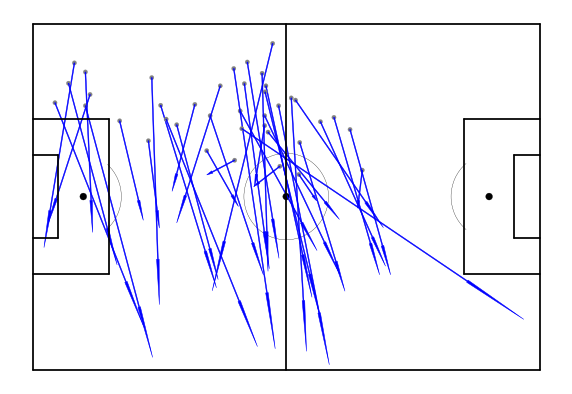

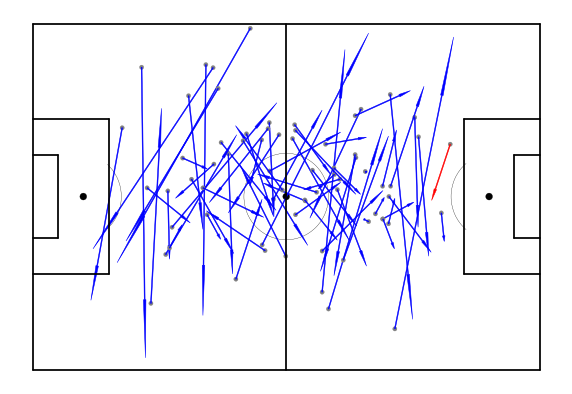

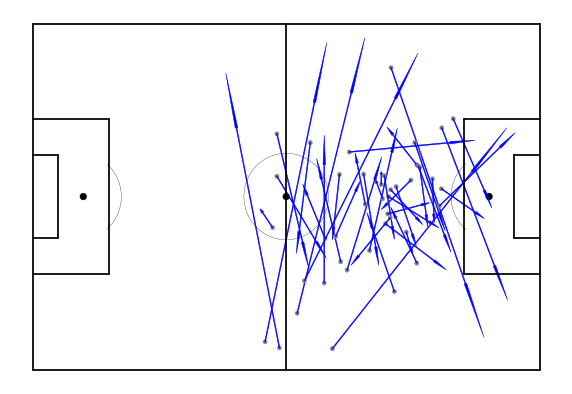

In [27]:
obj_players = ['Samuel Yves Umtiti','Sergio Busquets i Burgos','Lionel Andrés Messi Cuccittini']
for n,p in enumerate(obj_players):
    data = get_passes_train_data(p)
    show_player_passes(p,data)

Observando las gráficas se puede entender el posicionamiento y el estilo de juego de estes jugadores. Comenzando por Umtiti está claro que se trata del defensa central izquierdo del equipo ya que la gran mayoría de sus pases parten desde el lado izquierdo del terreno. Su principal labor, aparte de conectar el central derecho, es enviar balones a la banda contraria mediante desplazamientos largos. Son pocas las ocasiones en las que realiza un desplazamiento hacia delante del balón (en el partido estudiado solo lo hace una vez). Busquest, en cambio, ocupa gran parte del terreno por su posición de mediocentro y sus pases se reparten hacia el lado, hacia delante y hacia atrás, incluso uno de ellos propició un disparo de un compañero cuando se acercó al área rival. Messi, por último, a pesar de ser delantero goza de mucha relevancia en el sistema de pases del F.C. Barcelona. A diferencia de los otros dos, la mayoría de sus acciones de concentran cerca del área y, en ese partido, trató de conectar con sus compañeros a través de pases cuyo destino estaba dentro del área rival.

El siguiente paso es encontrar qué tipos de pase realizaron los tres jugadores en ese partido según el algoritmo de clustering que se aplica. Para ello se utiliza el algoritmo KMeans provisto por la librería Scikit-learn. Para obtener el número de grupos ideal se utilizará otra función, esta vez de la librería Yellowbrick, la cual realiza el método del codo a través de una métrica a elegir (distorsión).

Analisis de los pases de Samuel Y. Umtiti


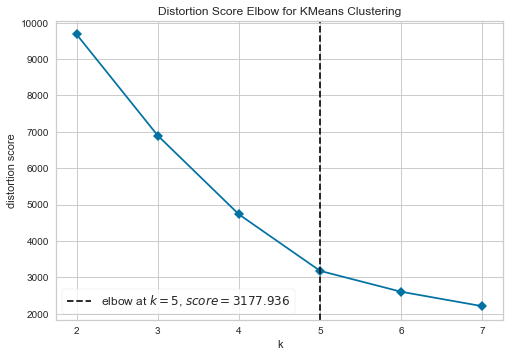

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
alg = KMeans()
vis = KElbowVisualizer(alg, k=(2,8), timings=False) # De 2 a 8 tipos de pases diferentes
# Representación
print('Analisis de los pases de Samuel Y. Umtiti')
umtiti_data = get_passes_train_data('Samuel Yves Umtiti')
vis.fit(umtiti_data[['X','Y','Distance','Direction','Height']])
vis.show()

Analisis de los pases de Sergio Busquets


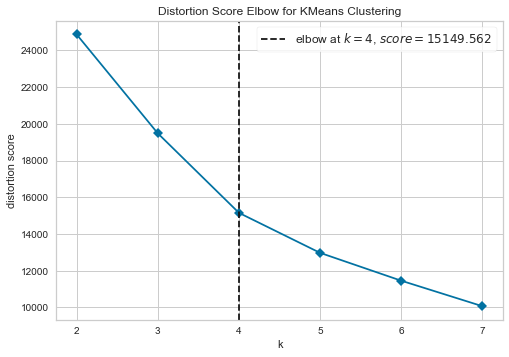

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
alg = KMeans()
vis = KElbowVisualizer(alg, k=(2,8), timings=False) # De 1 a 8 tipos de pases diferentes
# Representación
print('Analisis de los pases de Sergio Busquets')
busquets_data = get_passes_train_data('Sergio Busquets i Burgos')
vis.fit(busquets_data[['X','Y','Distance','Direction','Height']])
vis.show()

Analisis de los pases de Lionel A. Messi


C:\Users\jorgi\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jorgi\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


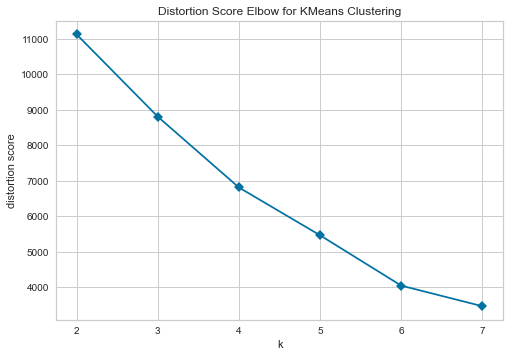

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
alg = KMeans()
vis = KElbowVisualizer(alg, k=(2,8), timings=False) # De 1 a 8 tipos de pases diferentes
# Representación
print('Analisis de los pases de Lionel A. Messi')
messi_data = get_passes_train_data('Lionel Andrés Messi Cuccittini')
vis.fit(messi_data[['X','Y','Distance','Direction','Height']])
vis.show()

Mientras que para Umtiti y Busquets encuentra 4 y 5 tipos de pases distintos. Según indica la función utilizada, esto puede deberse a una mala elección de los atributos del modelo. Un posible candidato a eliminar son las coordenadas exactas donde se realiza el pase ya que, en numerosas ocasiones, es más eficiente saber en qué parte del campo (si está más cercano a la portería o no) se encuenta el jugador en el momento de dar el pase. Para ello se debe modificar la función con la que se obtenían los datos de entrenamiento y probar con los tres jugadores de nuevo.

In [31]:
# Modificación del método
def get_passes_train_data_(player):
    # Escoger los de un jugador en jugada normal
    player_regular_play_passes = passes[(passes['play_pattern_name'] == 'Regular Play') & (passes['player_name'] == player)]
    res = pd.DataFrame(columns=['X','Y','dX','dY','Position','Distance','Direction','Height','S_Assist','G_Assist']) # Matriz resultado
    for i, pass_ in player_regular_play_passes.iterrows():
        res.at[i,'X'] = pass_['location'][0]
        res.at[i,'Y'] = pitchWidthY - pass_['location'][1] # Ataque de izquierda a derecha
        res.at[i,'dX'] = pass_['pass_end_location'][0]
        res.at[i,'dY'] = pass_['pass_end_location'][1]
        # Zona del campo -> Primer cuarto, Segundo cuarto, tercer cuarto y último cuarto.
        res.at[i,'Position'] = 0
        if pass_['location'][0] >= 0 and pass_['location'][0] < 30:
            res.at[i,'Position'] = 1
        elif pass_['location'][0] >= 30 and pass_['location'][0] < 60:
            res.at[i,'Position'] = 2
        elif pass_['location'][0] >= 60 and pass_['location'][0] < 90:
            res.at[i,'Position'] = 3
        elif pass_['location'][0] >= 90 and pass_['location'][0] <= 120:
            res.at[i,'Position'] = 4
        res.at[i,'Distance'] = pass_['pass_length'] # En yardas
        res.at[i,'Height'] = int(pass_['pass_height_id']) # 1: Raso, 2: Bajo, 3: Alto
        # Cálculo de la dirección
        direction = get_direction(pass_['pass_angle'])
        res.at[i,'Direction'] = direction # 1: Hacia delante, 2: Hacia los lados, 3: Pase atrás
        # Es pase que precede a un disparo
        res.at[i,'S_Assist'] = 0
        if 'pass_shot_assist' in pass_ and pass_['pass_shot_assist'] == True:
            res.at[i,'S_Assist'] = 1
        # Es pase que precede a un gol
        res.at[i,'G_Assist'] = 0
        if 'pass_goal_assist' in pass_ and pass_['pass_goal_assist'] == True:
            res.at[i,'G_Assist'] = 1
    return res

def get_elbow(player_data,name):
    alg = KMeans()
    vis = KElbowVisualizer(alg, k=(2,8), timings=False) # De 2 a 8 tipos de pases diferentes
    # Representación
    vis.fit(player_data[['Position','Distance','Direction','Height']])
    # vis.show(outpath="visual/kelbow_" + name + ".png")

Analisis de los pases de Samuel Y. Umtiti


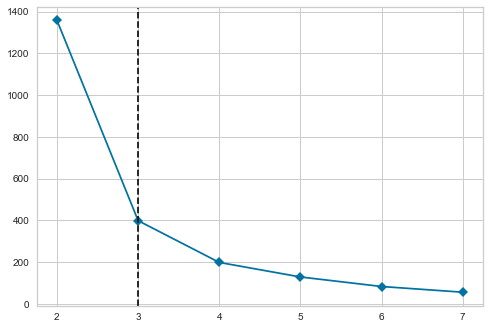

In [32]:
print('Analisis de los pases de Samuel Y. Umtiti')
umtiti_data = get_passes_train_data_('Samuel Yves Umtiti')
get_elbow(umtiti_data,'umtiti')

Analisis de los pases de Sergio Busquets


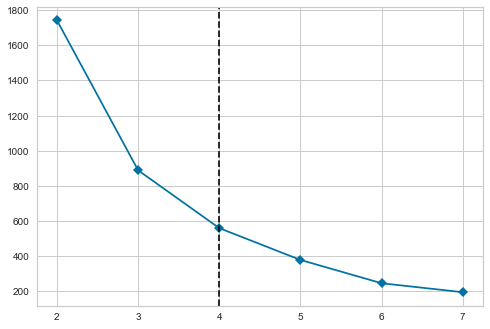

In [33]:
print('Analisis de los pases de Sergio Busquets')
busquets_data = get_passes_train_data_('Sergio Busquets i Burgos')
get_elbow(busquets_data,'busquets')

Analisis de los pases de Lionel A. Messi


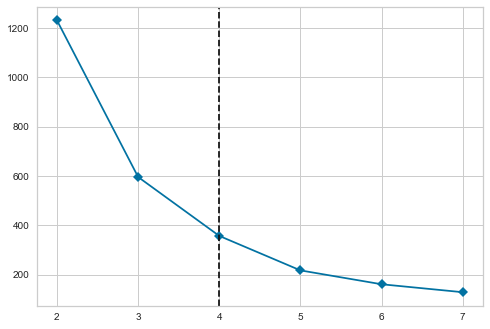

In [34]:
print('Analisis de los pases de Lionel A. Messi')
messi_data = get_passes_train_data_('Lionel Andrés Messi Cuccittini')
get_elbow(messi_data,'messi')

Con esta modificación se obtienes 3 tipos para Umtiti y 4 para Busquets y Messi. El cambio ha propiciado que el algoritmo sea capaz de identificar un número determinado de patrones en los pases de cada jugador. Se procede a identificar estos tipos mediante una representación gráfica.

In [35]:
def clustering_representation_(player, save_images=False):
    player_data = get_passes_train_data_(player)
    # Obtención de los grupos
    alg = KMeans()
    vis = KElbowVisualizer(alg, k=(2,8), timings=False)
    vis.fit(player_data[['Position','Distance','Direction','Height']])
    optimal_k = vis.elbow_value_
    # Algoritmo KMeans para etiquetar cada pase
    kmeans = KMeans(n_clusters=optimal_k).fit(player_data[['Position','Distance','Direction','Height']])
    # Se añade a los datos del jugador
    res = player_data
    res['Label'] = kmeans.labels_
    # Representación
    (fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
    for i,pass_ in player_data.iterrows():
        x,y = pass_['X'],pass_['Y']
        dx,dy = pass_['dX']- x,pass_['dY']-y
        color = colors[pass_['Label']]
        event = plt.Circle((x,y),0.5,color=color)
        arrow = plt.Arrow(x,y,dx,dy,linewidth=0.5,color=color)
        ax.add_patch(event)
        ax.add_patch(arrow)
    fig.set_size_inches(10, 7)
    if save_images:
        fig.savefig('visual/player_passes_clustering' + str(save_images) + '.png')
    plt.show()

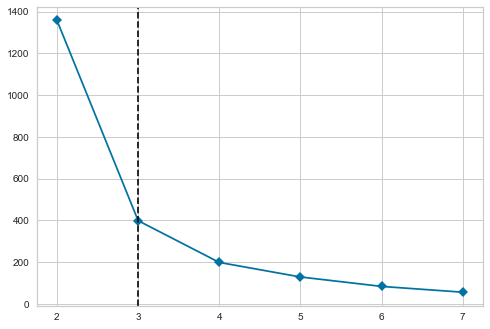

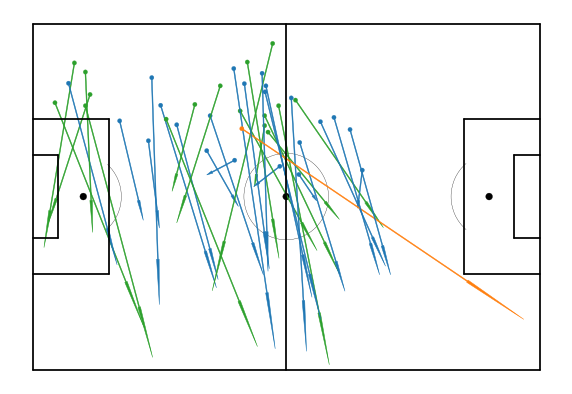

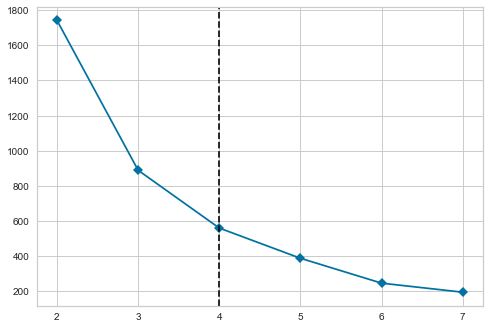

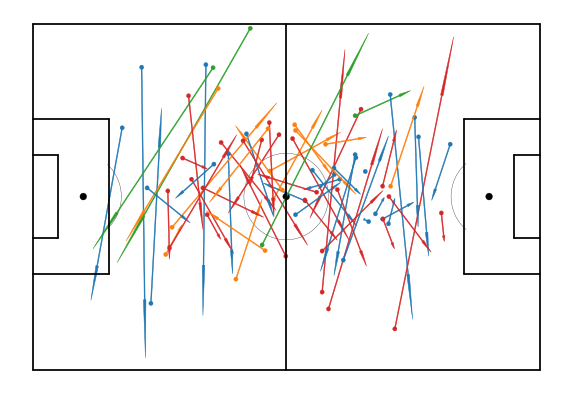

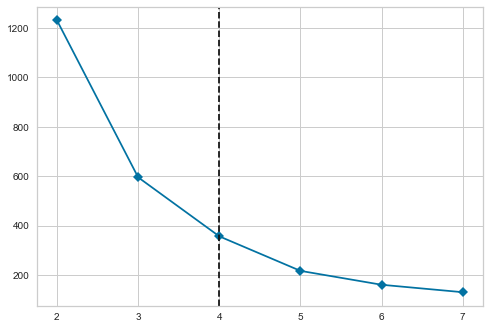

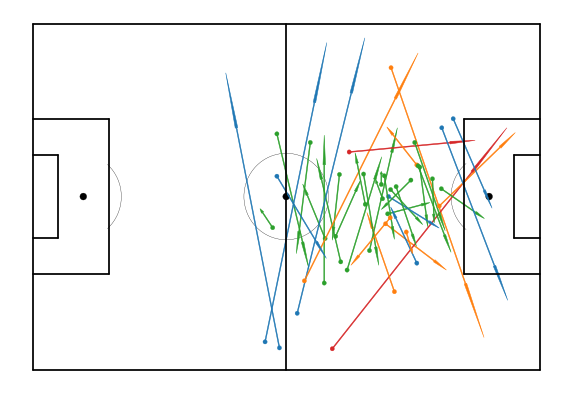

In [36]:
for n,p in enumerate(obj_players):
    clustering_representation_(p)

Los resultados reciben varias interpretaciones (se debe tener en cuenta que los colores se han podido ver modificados tras una nueva ejecución):
- Umtiti realiza tres tipos de pases diferentes en ese partido. Uno de ellos, con un solo representante, es el que dirige hacia el campo rival. Los otros dos son tipos muy similares que se identifican con la tarea principal del jugador: enviar el balón a los jugadores que juegan por la banda derecha.
- En la imagen de Busquets se dejan ver pases centrados en el campo con poco recorrido con los que se busca adelantar la posición del balón (coloreados en azuñ), otros que se parecen a los anteriores aunque presentan un carácter conservador ya que son horizontales o hacia atrás en su mayoría (rojo) y dos últimos tipos que se asemejan mucho, correspondiéndose con desplazamientos en largo.
- Messi presenta un tipo de pases muy directo al área (en verde), otros de desplazamientos en largo y el más común (en naranja), que se corresponde con los desplazamientos cortos que efectúa a mitad del campo rival.

Esta información puede ser muy útil para el entrenador del equipo rival. Por ejemplo, a través de la gráfica de Umtiti este podría dar instrucciones a sus delanteros para que cubran al central del F.C. Barcelona con el fin de evitar sus desplazamientos. Los mismos delanteros podrían no necesitar estar atentos a desplazamientos hacia su portería ya que Umtiti no recurre a este tipo de pases.

La clasificación por tipos de los pases de un jugador podría alimentar un sistema de predicción de pases. Para ello habría que estudiar si realizar un tipo de pase por parte de un jugador supone mayor acierto en la acción o no. También, tal y como se ha mencionado anteriormente, este sistema puede escalar para tratar la información de eventos de varios partidos con el fin de identificar las características de pase de un jugador.

#### ANEXO. Estudio de la direción

Se pretende trasnformar la información del ángulo, que está en radianes, a un grupo discreto que identifique cada pase con su dirección. Si va hacia delante será marcado con 1, si es un pase al lado será 2 y si es hacia atrás, un 3.

In [40]:
xd = passes[['location','pass_angle','pass_end_location']]
xd[:5]

,location,pass_angle,pass_end_location
4,"[61.0, 40.1]",-1.249046,"[61.4, 38.9]"
7,"[63.6, 37.2]",-0.377530,"[92.6, 25.7]"
13,"[35.6, 52.1]",2.514850,"[29.8, 56.3]"
25,"[87.1, 12.4]",-2.750545,"[75.7, 7.7]"
29,"[74.0, 10.3]",2.797471,"[56.7, 16.5]"


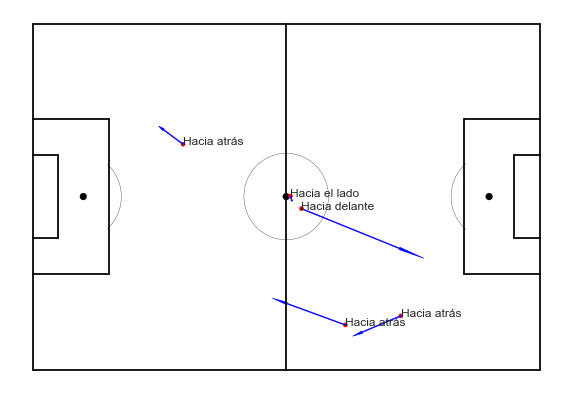

In [41]:
direction_ = ['Error', 'Hacia delante', 'Hacia el lado', 'Hacia atrás']
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
for i,pass_ in xd[:5].iterrows():
    event = plt.Circle((pass_['location']),0.5,color='red')
    x,y = pass_['location']
    dx,dy = np.subtract(pass_['pass_end_location'],pass_['location'])
    arrow = plt.Arrow(x,y,dx,dy,linewidth=0.5,color='blue')
    plt.annotate(direction_[get_direction(pass_['pass_angle'])],(x,y))
    ax.add_patch(event)
    ax.add_patch(arrow)
fig.set_size_inches(10, 7)
plt.show()

Bastaría con dividir la mitad de una circunferencia (valores entre 0 y pi) en tres partes iguales. 
- \[0,pi/4\] será 1.
- \[pi/4,3pi/4\] será 2.
- \[3pi/4,pi\] será 3.

También aparecen valores en negativo, hecho que se soluciona tomando el valor absoluto de los radianes para que entre en la clasificación anterior.